In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import h5py
import pickle

In [3]:
sys.path.append("../..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_mu_fq_output, load_gamma_fq_output, load_pion_fq_output
from WatChMaL.analysis.performance_analysis_utils import remove_indices

In [32]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2, "$\pi^0$":3}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$", 3:"$\pi^0$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

dark_red   = (0.6,0,0)
red        = (1,0,0)

dark_green = (0,0.25,0)
green      = (0,0.8,0)

dark_blue  = (0,0,0.5)
blue       = (0,0.8,0.8)

## Load fitqun results

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
pion_file_path  = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_pi0_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fitqun_comparison_prep/prep_data/4_class_3M_fitqun_mapping.pickle'

with open('./prep_data/4_class_3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

## Load resnet results

In [6]:
############# define run locations #############
short_locs = [#'/home/jtindall/WatChMaL/outputs/2021-04-06/13-38-38/outputs'
              '/home/jtindall/WatChMaL/outputs/2021-04-13/15-55-14/outputs'
              ]

short_titles = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0], c[1]]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[2], c[3]]
full_linestyle = [':' for _ in range(2)]


In [7]:
############# load short tank run data #############
short_idx_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'

short_indices = np.load(short_idx_file_path)['test_idxs']

short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [8]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## Plot e/gamma ROC Comparison

### Add fitqun results

In [9]:
gamma_fq_scores_1, gamma_fq_labels_1, _, _ = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path, discriminator='e_v_mu')

short_output_softmax = short_raw_output_softmax + [gamma_fq_scores_1] 
short_actual_labels  = short_raw_actual_labels + [gamma_fq_labels_1] 

In [10]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

### Plot All Discriminants

In [11]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(filtered_short_softmax[:1], filtered_labels[:1], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=True)

fq_fpr_list, fq_tpr_list, fq_thr_list = multi_compute_roc(filtered_short_softmax[1:], filtered_labels[1:], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=False)

In [12]:
fpr_list = short_fpr_list + fq_fpr_list
tpr_list = short_tpr_list + fq_tpr_list
thr_list = short_thr_list + fq_thr_list

In [13]:
gamma_linestyle = ['--' for _ in range(4)]
gamma_linecolor = [c[i] for i in range(4)]
gamma_titles    = ['Short Tank ResNet (4-Class)', 'Short Tank Fitqun']

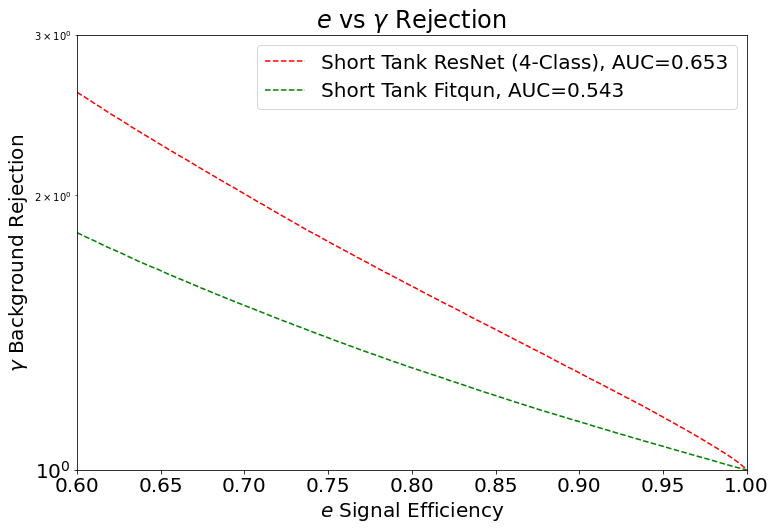

In [14]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,3e0]], 
                      linestyles=gamma_linestyle,linecolors=['r', 'g'], plot_labels=gamma_titles, show=False)

## Binned in Energy

In [15]:
from WatChMaL.analysis.performance_analysis_plot_utils import plot_true_momentum_binned_performance, plot_energy_binned_performance, plot_fitqun_binned_performance, plot_momentum_binned_performance, plot_joint_legend

In [16]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emgp0_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [17]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_4_class_3M_emgp0_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]

In [21]:
d_to_wall = np.load('./prep_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall']

In [22]:
true_mom = np.load('./prep_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta']

## Make Energy Plot

In [23]:
fq_scores, fq_labels, fq_mom, fq_masses = load_mu_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [fq_scores]
short_actual_labels  = short_raw_actual_labels + [fq_labels]

In [24]:
cut_to_apply = cuts['fq_comparison']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall, cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_angles    = remove_indices(test_angles, cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]
filtered_test_labels    = remove_indices(test_labels, cut_to_apply)

scores_list = [1 - filtered_short_softmax[0][:,2], filtered_short_softmax[1][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1]]
names  = ['ResNet (P(e-) + P(\u03B3))', 'FiTQun']
colors = ['r', 'g']

<AxesSubplot:title={'center':'$e$ Signal Efficiency vs Energy At Reconstructed Momentum\nFixed Bin $\\mu$ Mis-ID Rate'}, xlabel='Energy [MeV/$c^2$]', ylabel='$e$ Signal Efficiency'>

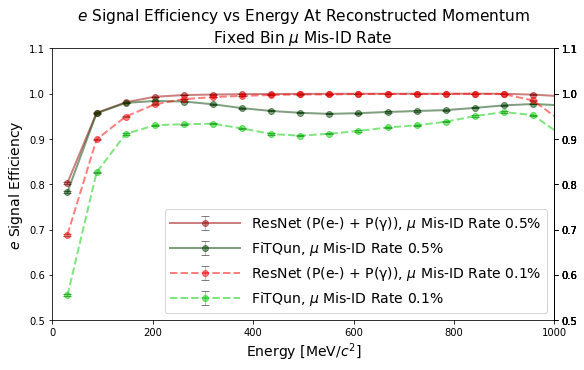

In [44]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')

yrange = [0.5, 1.1]
num_bins = 20

plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = 0.005, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = num_bins,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = [dark_red, dark_green],
                                 marker                 = 'o-',
                                 xrange                 = [0, 1000],
                                 ax                     = axes,
                                 yrange                 = yrange
                               )



plot_energy_binned_performance(scores_list              = scores_list, 
                                 labels_list            = labels_list,
                                 reconstructed_momentum = filtered_fq_mom,
                                 energy_features        = filtered_test_energies,
                                 fpr_fixed_point        = 0.001, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = num_bins,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = [red, green],
                                 xrange                 = [0, 1000],
                                 ax                     = axes,
                                 yrange                 = yrange
                               )

## Plot e/Pi0 ROC Comparison

### Add fitqun results

In [45]:
pion_fq_scores, pion_fq_labels, pion_fq_mom, pion_fq_masses = load_pion_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [pion_fq_scores]
short_actual_labels  = short_raw_actual_labels + [pion_fq_labels]

### Filter results

In [46]:
cut_to_apply = cuts['fq_comparison_pi0']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

In [47]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(filtered_short_softmax[:1], filtered_labels[:1], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\pi^0$"],
                            normalize=True)

fq_fpr_list, fq_tpr_list, fq_thr_list = multi_compute_roc(filtered_short_softmax[1:], filtered_labels[1:], 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\pi^0$"],
                            normalize=False)

In [48]:
fpr_list = short_fpr_list + fq_fpr_list
tpr_list = short_tpr_list + fq_tpr_list
thr_list = short_thr_list + fq_thr_list

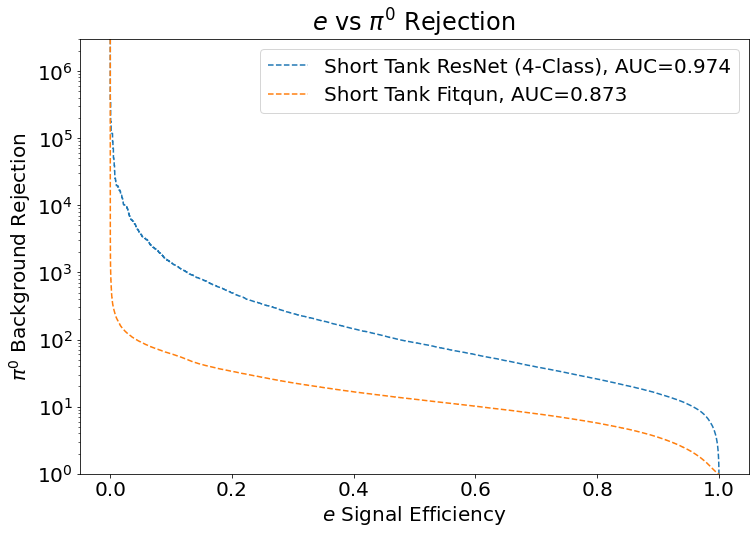

In [49]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\pi^0$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

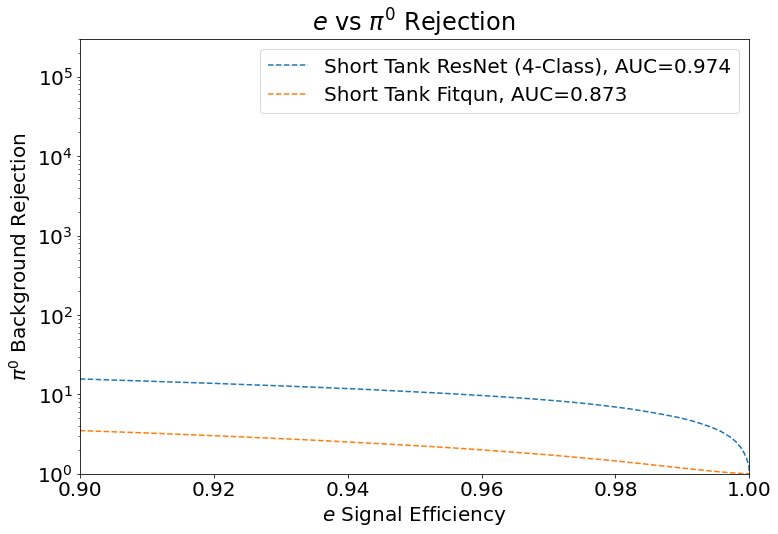

In [50]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\pi^0$",
                      fig_list=[1], xlims=[[0.9, 1.0]], ylims=[[1,3e5]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

## Pion Plots

In [51]:
from WatChMaL.analysis.performance_analysis_plot_utils import plot_to_wall_binned_performance, plot_single_var_pion_binned_performance

In [52]:
pion_fq_scores, pion_fq_labels, pion_fq_mom, pion_fq_masses = load_pion_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path)

short_output_softmax = short_raw_output_softmax + [pion_fq_scores]
short_actual_labels  = short_raw_actual_labels + [pion_fq_labels]

In [53]:
cut_to_apply = cuts['fq_comparison_pi0']

filtered_short_softmax  = [remove_indices(softmax, cut_to_apply) for softmax in short_output_softmax]
filtered_labels         = [remove_indices(labels, cut_to_apply) for labels in short_actual_labels]

filtered_fq_mom         = remove_indices(fq_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_to_wall   = remove_indices(test_d_to_wall, cut_to_apply)
filtered_test_true_mom  = remove_indices(test_true_mom, cut_to_apply)
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)
filtered_test_angles    = remove_indices(test_angles, cut_to_apply)
filtered_test_zenith    = filtered_test_angles[:, 0]
filtered_test_azimuth   = filtered_test_angles[:, 1]

filtered_pion_fq_scores = remove_indices(pion_fq_scores, cuts['fq_comparison_pi0'])
filtered_pion_fq_labels = remove_indices(pion_fq_labels, cuts['fq_comparison_pi0'])
filtered_pion_fq_mom    = remove_indices(pion_fq_mom, cuts['fq_comparison_pi0'])
filtered_pion_fq_masses = remove_indices(pion_fq_masses, cuts['fq_comparison_pi0'])

scores_list = [(filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1]) / (filtered_short_softmax[0][:,0] + filtered_short_softmax[0][:,1] + filtered_short_softmax[0][:,3]), filtered_short_softmax[1][:,1]]
labels_list = [filtered_labels[0], filtered_labels[1]]
names  = ['ResNet (1 - P($\pi^0$))', 'ResNet P(e-) / (P(e-) + P($\pi^0$))']
colors = ['r', 'g']

In [54]:
p0 = [15, 30, 30, 475, 1075, 945, 370, 255, 220, 195, 210, 160, 165, 190, 330, 205, 260, 290, 530, 555]
p1 = [-1.2, -6.5, -1.2, -7.6, -14.9, -13.8, -4.8, -2.9, -2.5, -2.5, -3.4, -2, -2.3, -3.2, -7.9, -3.8, -6.1, -6.8, -17.1, -19.7]

Empty bin
Empty bin


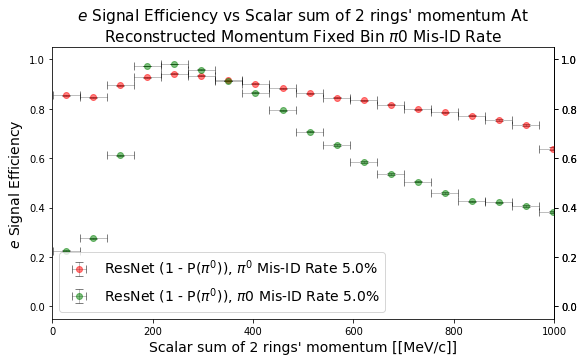

In [55]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_momentum_binned_performance(scores_list            = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 marker                 = 'o',
                                 xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )


plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_pion_fq_mom,
                                      plot_bin_label         = 'Scalar sum of 2 rings\' momentum',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      title_note             = '',
                                      names                  = names,
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      publication_style      = True
                                      )


Empty bin
Empty bin


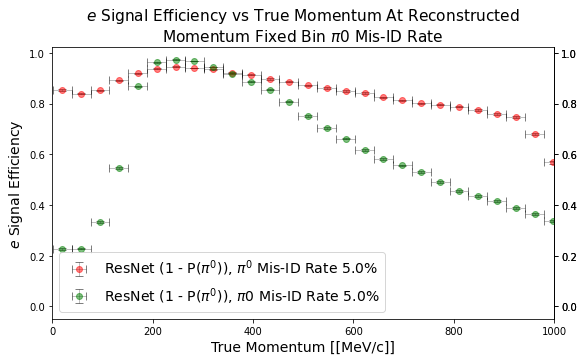

In [56]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_true_momentum_binned_performance(scores_list       = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 momentum_features      = filtered_test_true_mom,
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 names                  = names,
                                 colors                 = colors,
                                 marker                 = 'o',
                                 xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )

plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_test_true_mom,
                                      plot_bin_label         = 'True Momentum',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      title_note             = '',
                                      names                  = names,
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      publication_style      = True
                                      )


Empty bin
Empty bin


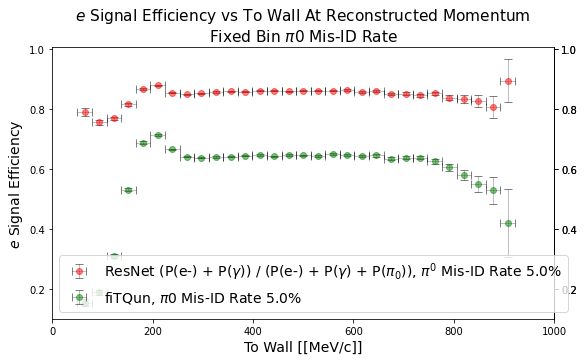

In [57]:
fig, axes = plt.subplots(1,1,figsize=(9,5), facecolor='w')


plot_to_wall_binned_performance(scores_list            = [scores_list[0]], 
                                 labels_list            = [labels_list[0]],
                                 reconstructed_momentum = filtered_pion_fq_mom,
                                 fpr_fixed_point        = 0.05, 
                                 to_wall_features       = filtered_test_to_wall,
                                 index_dict             = label_dict, 
                                 recons_mom_bin_size    = 50, 
                                 plot_bins              = 30,
                                 title_note             = '',
                                 colors                 = colors,
                                 names                  = ['ResNet (P(e-) + P($\gamma$)) / (P(e-) + P($\gamma$) + P($\pi_0$))'.format(0.005*100)],
                                 marker                 = 'o',
                                 xrange                 = [0, 1000],
                                 #yrange                 = yrange,
                                 ax                     = axes,
                                 desired_labels         = ['$e$',"$\pi^0$"],
                                 show_x_err             = True
                               )


plot_single_var_pion_binned_performance(scores               = scores_list[1],
                                      labels                 = labels_list[1],  
                                      fixed_binning_features = filtered_pion_fq_mom,
                                      fixed_bin_label        = 'Reconstructed Momentum',
                                      plot_binning_features  = filtered_test_to_wall,
                                      plot_bin_label         = 'To Wall',
                                      p0                     = p0, 
                                      p1                     = p1, 
                                      pi0mass                = filtered_pion_fq_masses,
                                      fpr_fixed_point        = 0.05, 
                                      index_dict             = label_dict, 
                                      fixed_bin_size         = 50, 
                                      plot_bins              = 30, 
                                      xrange                 = [0, 1000],
                                      marker                 = 'o',
                                      color                  = 'g',
                                      names                  = ['fiTQun'],
                                      title_note             = '',
                                      metric                 = 'efficiency',
                                      #yrange                  = [0.85, 1.01]
                                      ax                     = axes,
                                      publication_style      = True
                                      )
